# Savor Data

> Taking advantage of my own big data.

* toc: true
* badges: true
* author: Tobias Reaper
* comments: false
* categories: [EDA]

---

## Introduction

> Take advantage of your own big data.

Savor is a project based on an idea that I first had in 2016. At the time I was working as a consultant for an enterprise resource planning (ERP) software company. I worked intimately with manufacturers to integrate our system into their business, with the goal of optimizing their manufacturing processes. I became fascinated by the idea of tracking and planning various aspects of my life in a similar manner. I began to imagine what it would be like to have a similar type of system that I could use to optimize my life.

That's the core idea: building a system to organize my life as if it were an interconnected series of manufacturing processes.

Saying it may initially seem somewhat impersonal; I believe it's the opposite: the goal is to use data and software to understand myself better. That's where the tagline comes from — I'd like to take advantage of my own big data to make my life better in whatever ways I see fit at any given time.

Companies like Google and Facebook have been taking advantage of my big data for years, with the primary goal of making money. In the process of segmenting and profiling me, they've grown to know a lot about me. I'd like to have a similar data-driven profile of my life, for my own purposes. Namely, to learn more about myself and my life; to be able to optimize it.

I guess it's at this point that I can see people rolling their eyes and thinking this is just another productivity app — words like "optimize" don't help things. However, I want to get across the fact that because I have total control over this system, I get to choose exactly how it gets used and precisely what is optimized. While sometimes this optimization would come in the form of making myself more productive, it's equally likely that I'll want to optimize the length of time and quality of connection I have with family and friends.

Imagine that: a system that can help you find time to spend with family and friends, and find mindsets and/or conversation topics that will most likely increase the quality of those connections.

I think that sounds like the opposite of impersonal — getting intimate with oneself on levels and to a degree potentially not possible before.

### Real-time Journal

I have many ways of describing the vision I have for the app, but one of the key features which communicates the value is the "real-time journal".

My goal with this is to streamline the data capture part of the process such that capturing the data of everyday life — everyday experience — in real-time is not only possible, but easy and intuitive. Much of the resolution of memory is lost soon after events happen; best to document that experience as soon as possible with the important details that one might easily forget.

The added benefit to this is that with a real-time journal such as this, one starts to accumulate large amounts of data about one's own life. With the right tools, this data can lead to a deeper understanding of many aspects of life.

I've been capturing this kind of data for the past ~2.5 years, and have accumulated over 26,000 records detailing just about every minute of every day.

Of course at the beginning the process was clunky, the data models crude. Over time, I continued to work on it until it became second nature; a background task that just happens. I improved the data models, which of course caused some compatibility issues between the new and old data.

I'm still working on getting all 26k records in a single dataset. For now — i.e. in this notebook — I'm going to use the data I've gathered using the latest iteration of the data model, implemented at the beginning of December 2019. Therefore, this notebook will be using 12,297 records constituting ~10 months of data.

### Data Model

I'll be going into more detail in proceeding notebooks and analyses, but it will be useful to this one to give a brief overview of how the journal data is structured.

The latest data model of my journal has 3 distinct layers, in descending order of granularity:

1. Project Log
2. Engagement Log
3. Moment Log

At the top level, I try to work on a single "project" for a certain period of time. This helps me stay focused on what I wanted to do/work on during that time. Another way to think about it is that this level defines overarching parts of the day, usually somewhere between 5 and 10, depending on what the day looks like.

Within each "project block" I switch between specific activities, such as between coding, writing, and reading/research. That is the second level, with each individual activity, or "engagement", assigned to that higher level block in a many-to-one relationship. The second level is where the vast majority of the action is; where I document most of my experiences.

The third level is for very short activities I do that aren't necessarily related to the main activity. For example, I could be working on the notebook to explore this data but take short little breaks to get water, use the restroom, or clear my head. In the previous iteration of the data model I didn't account for these little activities — every activity was "created equal", so to speak. Thus, in order to account for that time, I'd have to split up and duplicate the main engagement record, interspersing the short breaks into them that way. Simply put, that caused too much overhead.

The goal with this project is to reduce the time and effort required to keep a real-time journal to the point where it doesn't interrupt what I'm actually doing.

### Notebook in context

I wanted to explain about the project and how the data is set up to give some context. The last bit of context for now is how this notebook fits into the project.

> This notebook will focus primarily on exploring the `engage_log` table.

The primary features I'll be exploring in this notebook are:

* `time_in`
* `time_out`
* `duration`
* `mental`
* `physical`
* `mental_note`
* `physical_note`

There are many others that I could and will use, but I'll save those for another notebook.

I'm starting with this table because it is the experiential layer in which most of my experience is documented. The other layers are mostly there to support the `engage_log`, whether to provide, along with other structural benefits, a group index (`project_log`), or to append additional details (`moment_log`).

With all the basics out of the way, let's get into it!

### Imports and Config

In [1]:
# === Some initial imports and config === #
from os import environ
from pprint import pprint

# Data manipulation
import pandas as pd
import numpy as np
import janitor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas config
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Accessing the data

I'm currently working on a pipeline between Airtable (where the the data exists currently) and a local Postgres instance. Once that is complete, I'll load the data directly from there.

Until then, however, I'm going to load the data from CSVs I downloaded from the Airtable browser-based GUI.

In [2]:
# Load data from csv
data_path = "../../assets/data_/20-09-07-engage_log.csv"
engage_1 = pd.read_csv(data_path)

---

## Initial Wrangling

For the purposes of this notebook, the data is already relatively clean. There are just a few things to address before I can get into the exploration:

> Prune the dataset to the features being used in this notebook

As I mentioned above, I'm limiting the analysis in this notebook to a handful of features. Granted, they are some of the more important ones. But I don't want to get carried away this early in the analysis. The paradox of choice is a real thing; there is plenty to dig into with what I'm using, and I will really only be able to scratch the surface of these features in this notebook.

> Null values
 
The only null I'll be dropping is the one at the very end of the dataset. This is the record that hasn't ended yet, as of the moment of writing. The rest are just datapoints that I didn't gather, and can be filled with empty strings rather than dropped or imputed.

> Fix data types
  
There are only a couple of issues with data types that need to be addressed. First, datetime columns will have to be converted to the datetime datatype. Second, the way Airtable exports the data, `duration` is exported as a string that's really only useful to the eyes. That should be an integer.

### Pruning

In [3]:
# Clean up columns to only what's needed right now
print("Initial shape:", engage_1.shape)

engage_keep_cols = [
    "time_in",
    "time_out",
    "duration",
    "mental",
    "physical",
    "mental_note",
    "physical_note",
    "subloc",
    "project_location",
]

# Copy columns into new dataframe
engage_2 = engage_1[engage_keep_cols].copy()
print("After column pruning:", engage_2.shape)
engage_2.head(3)

Initial shape: (12297, 23)
After column pruning: (12297, 9)


,time_in,time_out,duration,mental,physical,mental_note,physical_note,subloc,project_location
0,2019-12-03 06:00,2019-12-03 06:19,19:00,Podcast,Exercise,Full Stack Radio - Evan Yue \\ Vue 3.0 + new e...,Cardio - elliptical,Elliptical,24hr-Bel
1,2019-12-03 06:19,2019-12-03 06:37,18:00,Podcast,Exercise,Full Stack Radio with Evan Yue \\ Vue 3.0 - fi...,Cardio - stairs,Stairmaster,24hr-Bel
2,2019-12-03 06:37,2019-12-03 07:02,25:00,Podcast,Exercise,Django Chat \\ Caching - something to read up ...,Weights - hip abduction in / out (machine) - k...,Machines,24hr-Bel


### Nulls

In [4]:
# The null in time_out and duration is the current record - can be removed
engage_3 = engage_2.dropna(axis=0, subset=["time_out"])
# Fill remaining nulls with empty string
engage_3 = engage_3.fillna(value="")
# Confirm it worked
engage_3.isnull().sum()

time_in             0
time_out            0
duration            0
mental              0
physical            0
mental_note         0
physical_note       0
subloc              0
project_location    0
dtype: int64

In [5]:
# Fix datetime columns
# from savor_code.pipelines import convert_datetime_cols

def convert_datetime_cols(data: pd.DataFrame, dt_cols: list) -> pd.DataFrame:
    """If datetime columns exist in dataframe, convert them to datetime.

    :param data (pd.DataFrame) : DataFrame with datetime cols to be converted.
    :param dt_cols (list) : List of potential datetime cols.
    :return (pd.DataFrame) : DataFrame with datetime cols converted.
    """
    data = data.copy()  # Don't change original dataframe
    for col in dt_cols:
        if col in data.columns:  # Make sure column exists
            data[col] = pd.to_datetime(data[col])
    return data

date_cols = [
    "time_in",
    "time_out",
]

engage_4 = convert_datetime_cols(engage_3, date_cols)

engage_4.dtypes

time_in             datetime64[ns]
time_out            datetime64[ns]
duration                    object
mental                      object
physical                    object
mental_note                 object
physical_note               object
subloc                      object
project_location            object
dtype: object

### Convert duration to minutes

The `duration` feature was imported as a string formatted like so: `[hh:]mm:ss`. To convert this into minutes, I'll split on the colon and extract the hours and minutes, multiplying the hours by 60 and adding them to the minutes. I can leave out the seconds, as I did not capture the timestamps at that level of detail.

Unfortunately, if the hour is not present in the record, it simply doesn't include that segment. Therefore, I had to write a custom function to both split and calculate the minutes.

In [6]:
def split_and_calculate_mins(column):
    """Splits up `duration` based on colon, accounting for missing hours.
    Expects format: [hh:]mm:ss."""
    # Split up cell into component parts
    segments = [int(s) for s in column.split(":")]
    # Check length - if more than 2, means hour is present
    if len(segments) > 2:
        # Calculate mins from hours and sum
        return (segments[0] * 60) + segments[1]
    elif len(segments) == 2:  # Case with mins:secs
        # Simply return the minutes
        return segments[0]
    else:  # Catch edge case when no duration
        return 0

In [7]:
# Use apply to convert duration to integer
engage_4["duration"] = engage_4["duration"].apply(split_and_calculate_mins)
engage_4.head()

,time_in,time_out,duration,mental,physical,mental_note,physical_note,subloc,project_location
0,2019-12-03 06:00:00,2019-12-03 06:19:00,19,Podcast,Exercise,Full Stack Radio - Evan Yue \\ Vue 3.0 + new e...,Cardio - elliptical,Elliptical,24hr-Bel
1,2019-12-03 06:19:00,2019-12-03 06:37:00,18,Podcast,Exercise,Full Stack Radio with Evan Yue \\ Vue 3.0 - fi...,Cardio - stairs,Stairmaster,24hr-Bel
2,2019-12-03 06:37:00,2019-12-03 07:02:00,25,Podcast,Exercise,Django Chat \\ Caching - something to read up ...,Weights - hip abduction in / out (machine) - k...,Machines,24hr-Bel
3,2019-12-03 07:02:00,2019-12-03 07:08:00,6,Podcast,Walk,Not so standard deviations \\ misc discussions...,Walked to locker room then to car,Outside,24hr-Bel
4,2019-12-03 07:08:00,2019-12-03 07:20:00,12,Podcast,Drive,SE Daily \\ TIBCO,,Trinity,24hr-Bel


In [8]:
engage_4.dtypes

time_in             datetime64[ns]
time_out            datetime64[ns]
duration                     int64
mental                      object
physical                    object
mental_note                 object
physical_note               object
subloc                      object
project_location            object
dtype: object

---

## Exploration and Visualization

There are so, so many interesting questions to ask and avenues to explore with this data. I'd been brainstorming casually over the years on the topic of how to tackle the exploratory analysis and visualization.

Here are a few ideas to get me started:

* How do I spend my time?
  * Time spent on each activity
  * What patterns does this follow on a daily/weekly/monthly time horizon?
* How much do I write about my experience?
  * Word and character counts: total, total/avg per month over time
* Sentiment analysis over time
  * Does my mood oscillate according to any discernable pattern?
  * Does my mood correlate with spending time on particular activities?

There's a lot more that can and will be done with this data. Best to leave it at that for now. In fact, I'll leave the sentiment analysis for a later notebook — the first two are enough to get started.

### How do I spend my time?

The `mental` and `physical` features include the mental or physical activities that I'm engaged in at any given moment. These are an obvious place to start exploring this question.

First, I find and visualize the top 10 mental and physical activities, by total time spent over the entire dataset. Then I break that up into monthly and weekly totals to get an idea of how my schedule has changed over the past 10 months.

In [9]:
# Make copy of dataframe to explore mental/physical activities
act_1 = engage_4[["time_in", "time_out", "duration", "mental", "physical"]].copy()
act_1.head()

,time_in,time_out,duration,mental,physical
0,2019-12-03 06:00:00,2019-12-03 06:19:00,19,Podcast,Exercise
1,2019-12-03 06:19:00,2019-12-03 06:37:00,18,Podcast,Exercise
2,2019-12-03 06:37:00,2019-12-03 07:02:00,25,Podcast,Exercise
3,2019-12-03 07:02:00,2019-12-03 07:08:00,6,Podcast,Walk
4,2019-12-03 07:08:00,2019-12-03 07:20:00,12,Podcast,Drive


In [10]:
# Get sets of all activities
mental_set = {act for acts in act_1["mental"] for act in acts.split(",")}
physical_set = {act for acts in act_1["physical"] for act in acts.split(",")}

# How many distinct activities?
print(len(mental_set))
print(len(physical_set))

51
65


#### Total time spent on activities

In [11]:
# Get total sum of activities using collections.Counter
from collections import Counter

# Counters for total time and total number of occurrences
mental_sums = Counter()
physical_sums = Counter()
mental_count = Counter()
physical_count = Counter()

# Iterate through all rows + lists within rows
for row in act_1.itertuples(index=False):
    # Split on comma, add time to each item
    for w in row[3].split(","):
        mental_count[w] += 1
        mental_sums[w] += row[2]
    for f in row[4].split(","):
        physical_count[f] += + 1
        physical_sums[f] += row[2]

In [12]:
# Look at top 10 activities by total time spent
print("Time spent on top 10 activities, in minutes")
print("Mental:")
for mental in mental_sums.most_common(10):
    print(f"  {mental}")
print("\nPhysical:")
for physical in physical_sums.most_common(10):
    print(f"  {physical}")

Time spent on top 10 activities, in minutes
Mental:
  ('Sleep', 129453)
  ('Converse', 72596)
  ('Code', 49092)
  ('Watch', 28160)
  ('Podcast', 21496)
  ('Audiobook', 21309)
  ('Information', 21146)
  ('Learn', 19914)
  ('Think', 19283)
  ('Write', 15077)

Physical:
  ('Rest', 152607)
  ('Sit', 86098)
  ('Stand', 70127)
  ('Drive', 13296)
  ('Eat', 11113)
  ('Cook', 8448)
  ('Dress', 7028)
  ('Dishes', 6124)
  ('Exercise', 6086)
  ('Dental hygiene', 5998)


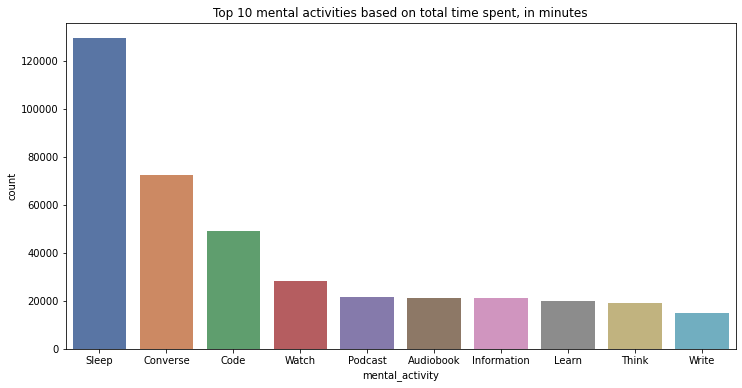

In [13]:
# Cast counter to dataframe and visualize
mental_bar_1 = (pd.DataFrame.from_dict(dict(mental_sums.most_common(10)), orient="index", columns=["count"])
                .reset_index()
                .rename_column("index", "mental_activity")
                )
# Visualize the top mental activities
plt.figure(figsize=(12, 6))
sns.barplot("mental_activity", "count", data=mental_bar_1, palette="deep");
plt.title("Top 10 mental activities based on total time spent, in minutes");

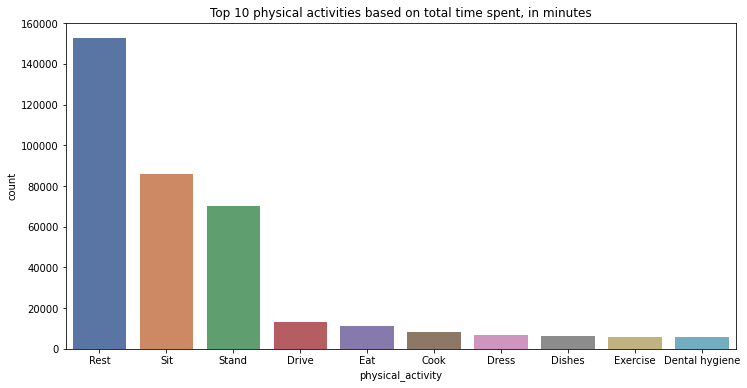

In [14]:
# Cast counter to dataframe and visualize
physical_bar_1 = (pd.DataFrame.from_dict(dict(physical_sums.most_common(10)), orient="index", columns=["count"])
                .reset_index()
                .rename_column("index", "physical_activity")
                )
# Visualize the top physical activities
plt.figure(figsize=(12, 6))
sns.barplot("physical_activity", "count", data=physical_bar_1, palette="deep");
plt.title("Top 10 physical activities based on total time spent, in minutes");

#### Monthly totals

To get a monthly sum of time spent on the top 10 activities, I encode each into its own feature — almost one-hot-encoding style, with the difference of using the `duration` value instead of `1` or `0`. With the data in this form, it is simple to group by month then sum to get monthly totals for each activity.

In [37]:
# Mental activites -> features
act_mental = act_1.copy()  # Copy to not mess with original dataframe

# Iterate through top 10
for mental in mental_sums.most_common(10):
    # Create new function to apply with each iteration
    def create_activity_feature_with_duration(df):
        """If activity is assigned, copy duration value into that new col."""
        if mental[0] in df["mental"]:
            return df["duration"]
    act_mental = act_mental.join_apply(create_activity_feature_with_duration, mental[0].lower())

# Example of duration value
act_mental[["time_in", "time_out", "duration", "podcast"]].head()

,time_in,time_out,duration,podcast
0,2019-12-03 06:00:00,2019-12-03 06:19:00,19,19.0
1,2019-12-03 06:19:00,2019-12-03 06:37:00,18,18.0
2,2019-12-03 06:37:00,2019-12-03 07:02:00,25,25.0
3,2019-12-03 07:02:00,2019-12-03 07:08:00,6,6.0
4,2019-12-03 07:08:00,2019-12-03 07:20:00,12,12.0


In [38]:
# Physical activites -> features
act_physical = act_1.copy()  # Copy to not mess with last dataframe
# Not adding to the same dataframe, as the visualizations will be separate

# Iterate through top 10
for physical in physical_sums.most_common(10):
    # Create new function to apply with each iteration
    def create_activity_feature_with_duration(df):
        """If activity is assigned, copy duration value into that new col."""
        if physical[0] in df["physical"]:
            return df["duration"]
    act_physical = act_physical.join_apply(create_activity_feature_with_duration, physical[0].lower())

act_physical[["time_in", "time_out", "duration", "drive", "exercise"]].head()

,time_in,time_out,duration,drive,exercise
0,2019-12-03 06:00:00,2019-12-03 06:19:00,19,NaN,19.0
1,2019-12-03 06:19:00,2019-12-03 06:37:00,18,NaN,18.0
2,2019-12-03 06:37:00,2019-12-03 07:02:00,25,NaN,25.0
3,2019-12-03 07:02:00,2019-12-03 07:08:00,6,NaN,NaN
4,2019-12-03 07:08:00,2019-12-03 07:20:00,12,12.0,NaN


Now that I have the top 10 activities as their own features with their `duration` values, I'll need to group by month.

There are multiple ways to accomplish this. One way would be to extract the month component of the `time_in` feature and use that as the grouping column. Or, I could set `time_in` as a DatetimeIndex index and use time-aware grouping methods.

I'm going to do the latter.

In [17]:
# Create lists of top activities
mental_top_activities = [m[0].lower() for m in mental_sums.most_common(10)]
physical_top_activities = [m[0].lower() for m in physical_sums.most_common(10)]

In [18]:
# Set `time_in` to index
act_mental_2 = act_mental.set_index(pd.DatetimeIndex(act_mental["time_in"]))
act_physical_2 = act_physical.set_index(pd.DatetimeIndex(act_physical["time_in"]))

In [19]:
# Group by month using Grouper
mental_by_month = act_mental_2.groupby(pd.Grouper(freq="M"))
physical_by_month = act_physical_2.groupby(pd.Grouper(freq="M"))

# Use lists to get sums from groupby
# Remove last month, as it would throw things off
mental_sum_by_month = mental_by_month[mental_top_activities].sum().drop(pd.to_datetime("2020-09-30"), axis=0)
physical_sum_by_month = physical_by_month[physical_top_activities].sum().drop(pd.to_datetime("2020-09-30"), axis=0)

In [20]:
#collapse
mental_sum_by_month

,sleep,converse,code,watch,podcast,audiobook,information,learn,think,write
time_in,,,,,,,,,,
2019-12-31,12838.0,7752.0,4878.0,3727.0,2118.0,1994.0,678.0,4175.0,2160.0,84.0
2020-01-31,14236.0,8193.0,3947.0,2643.0,1697.0,1403.0,1474.0,430.0,2530.0,674.0
2020-02-29,12164.0,6227.0,10743.0,1581.0,2164.0,2359.0,6010.0,794.0,1276.0,384.0
2020-03-31,13793.0,5364.0,8493.0,5044.0,1897.0,2991.0,606.0,2802.0,2636.0,606.0
2020-04-30,14778.0,5718.0,8614.0,7279.0,2001.0,2021.0,882.0,5910.0,1786.0,412.0
2020-05-31,15791.0,9451.0,3394.0,2428.0,2814.0,2156.0,1000.0,2658.0,2117.0,2913.0
2020-06-30,14278.0,8905.0,2619.0,1787.0,1519.0,1874.0,2081.0,720.0,2152.0,3608.0
2020-07-31,14090.0,11991.0,2877.0,2421.0,2092.0,2417.0,3932.0,1097.0,2091.0,2863.0
2020-08-31,15062.0,6997.0,2186.0,992.0,3852.0,3044.0,3714.0,490.0,2071.0,2757.0


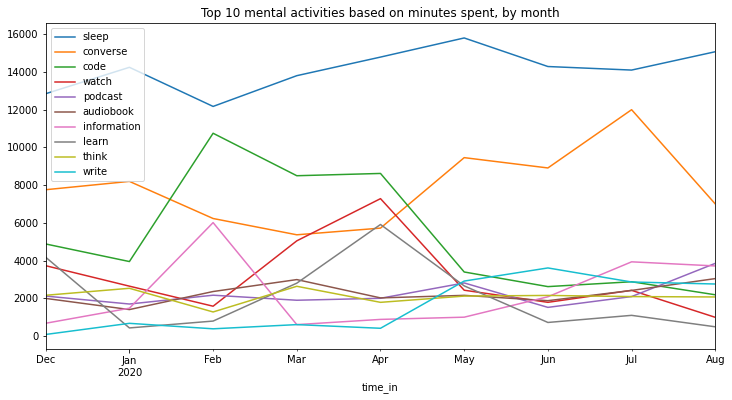

In [21]:
# Lineplot of monthly mental activity totals
mental_sum_by_month.plot(figsize=(12, 6))
plt.title("Top 10 mental activities based on minutes spent, by month");

Now we're talking! This has some interesting information in it.

For example, the increase in time spent coding (and relative decrease in sleep) from around February through March corresponds to when I was working on [Trash Panda](https://tobias.fyi/workshop/trash-panda/) (Jan - Mar) then studying computer science at Lambda School (Mar - May). Then as my job search began in earnest, the amount of time I spent networking (conversing) increased, while coding time unfortunately decreased.

In [22]:
#collapse
physical_sum_by_month

,rest,sit,stand,drive,eat,cook,dress,dishes,exercise,dental hygiene
time_in,,,,,,,,,,
2019-12-31,14961.0,10120.0,6474.0,1747.0,1486.0,805.0,736.0,524.0,607.0,833.0
2020-01-31,16424.0,6944.0,9166.0,549.0,1125.0,949.0,748.0,423.0,1150.0,490.0
2020-02-29,14181.0,9330.0,11372.0,1337.0,917.0,1052.0,386.0,674.0,37.0,975.0
2020-03-31,16282.0,11608.0,9726.0,420.0,1125.0,1286.0,1185.0,835.0,449.0,1470.0
2020-04-30,17553.0,11257.0,9801.0,153.0,1121.0,1430.0,651.0,1013.0,766.0,443.0
2020-05-31,17562.0,10693.0,3906.0,1954.0,1482.0,1241.0,1859.0,846.0,849.0,416.0
2020-06-30,17479.0,8644.0,4450.0,1691.0,1132.0,419.0,478.0,541.0,715.0,451.0
2020-07-31,18024.0,11246.0,3996.0,2626.0,1391.0,476.0,497.0,451.0,355.0,405.0
2020-08-31,17459.0,4958.0,9409.0,1615.0,1115.0,741.0,382.0,729.0,1128.0,424.0


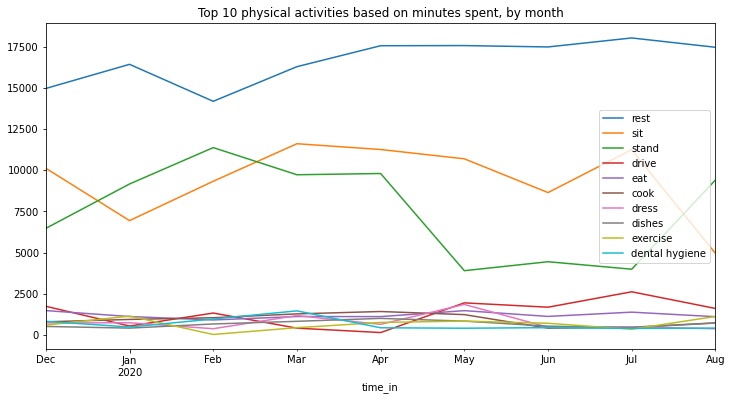

In [23]:
# Lineplot of monthly physical activity totals
physical_sum_by_month.plot(figsize=(12, 6))
plt.title("Top 10 physical activities based on minutes spent, by month");

One obvious and interesting aspect of my physical activities over time is the interplay between sitting and standing (and driving, to some extent). I say driving, because the period of time beginning around May is when I began to take road trips from Colorado to California to visit family. As I was not at my desk, I tended to not stand while working.

#### Weekly totals

I found the monthly totals to be an interesting overview of the data. But I figured weekly totals would be even more interesting. The process for manipulating the data is pretty much the same, just grouped by week instead of by month.

In [24]:
# Group by week using Grouper
mental_by_week = act_mental_2.groupby(pd.Grouper(freq="W"))
physical_by_week = act_physical_2.groupby(pd.Grouper(freq="W"))

# Use lists to get sums from groupby
# Remove last month, as it would throw things off
mental_sum_by_week = mental_by_week[mental_top_activities].sum().drop(pd.to_datetime("2020-09-13"), axis=0)
physical_sum_by_week = physical_by_week[physical_top_activities].sum().drop(pd.to_datetime("2020-09-13"), axis=0)

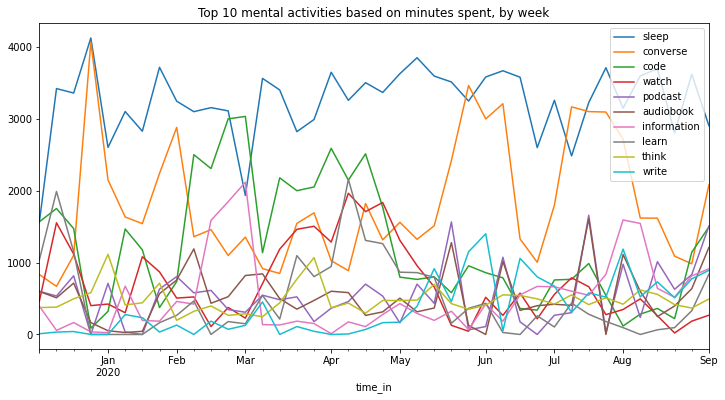

In [25]:
# Lineplot of weekly mental activity totals
mental_sum_by_week.plot(figsize=(12, 6))
plt.title("Top 10 mental activities based on minutes spent, by week");

The same basic patterns show up here as in the monthly groups, but with more detail (obviously). Although more detail is generally good, it does make the visualization a lot more hectic. It's a lot to look at.

The detail gives a better idea of when exactly my time spent conversing increased as drastically as it did this summer. Those two peaks correspond to when I travelled out to California to spend time with my family.

One part I see sticking out more in this than when looking at it monthly is the increase in time spent writing that starts in the middle of May. That is when I was finishing up a whole bunch of articles for my portfolio. Then, in June I committed to spending at least 10 extra minutes journaling at the end of the day.

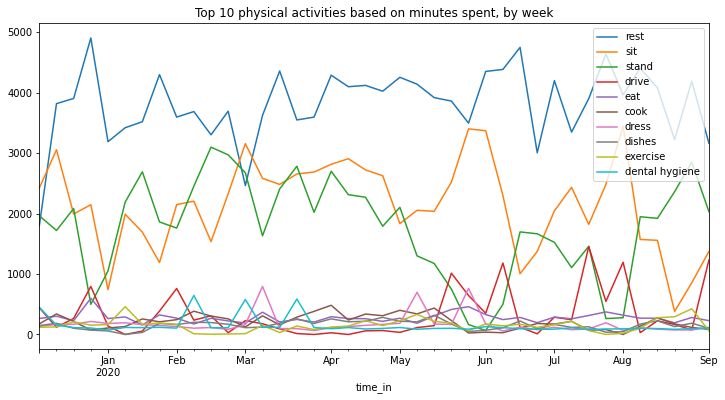

In [26]:
# Lineplot of weekly physical activity totals
physical_sum_by_week.plot(figsize=(12, 6))
plt.title("Top 10 physical activities based on minutes spent, by week");

The sitting/standing dynamic here is even more drastic and interesting. Even though they have a generally negative relationship, there is are times when both are increasing, like from January to March. I wonder where that time came from?

### How much I write about my experience

Seeing as this is a journal, I thought it would be interesting to look at how much I actually write in it. There are definitely times when I choose to spend more time on the actual writing part than others. I imagine that these patterns will be noticeable.

Here are the visualizations I'm going to generate:

* Total word count
* Total character count
* Word count over time, per month and week
* Character count over time, per month and week

In [27]:
# Copy dataframe to work on word/char counts
content_1 = engage_4.drop(columns=["time_out", "subloc", "project_location"])
content_1.head()

,time_in,duration,mental,physical,mental_note,physical_note
0,2019-12-03 06:00:00,19,Podcast,Exercise,Full Stack Radio - Evan Yue \\ Vue 3.0 + new e...,Cardio - elliptical
1,2019-12-03 06:19:00,18,Podcast,Exercise,Full Stack Radio with Evan Yue \\ Vue 3.0 - fi...,Cardio - stairs
2,2019-12-03 06:37:00,25,Podcast,Exercise,Django Chat \\ Caching - something to read up ...,Weights - hip abduction in / out (machine) - k...
3,2019-12-03 07:02:00,6,Podcast,Walk,Not so standard deviations \\ misc discussions...,Walked to locker room then to car
4,2019-12-03 07:08:00,12,Podcast,Drive,SE Daily \\ TIBCO,


To get the actual word and character counts, I use the pandas `.apply()` method along with simple lambda functions.

In [28]:
# Calculate word and character counts
content_2 = content_1.copy()  # Copy to isolate cell's effect on df

for feat in ["mental_note", "physical_note"]:
    content_2[f"{feat}_word_count"] = content_2[feat].apply(lambda x: len(x.split()))
    content_2[f"{feat}_char_count"] = content_2[feat].apply(lambda x: len(x))

In [29]:
# Set `time_in` to index
count_cols = [
    "mental_note_word_count",
    "physical_note_word_count",
    "mental_note_char_count",
    "physical_note_char_count",
]
content_3_counts_only = content_2.set_index(pd.DatetimeIndex(content_2["time_in"]))[count_cols].copy()
content_3_counts_only.head()

,mental_note_word_count,physical_note_word_count,mental_note_char_count,physical_note_char_count
time_in,,,,
2019-12-03 06:00:00,18,3,75,20
2019-12-03 06:19:00,16,3,78,16
2019-12-03 06:37:00,42,15,197,77
2019-12-03 07:02:00,9,7,59,33
2019-12-03 07:08:00,4,0,17,0


Once the counts are calculated, the process of grouping and visualizing is pretty much the same before.

In [30]:
# Group by week using Grouper
counts_by_week = content_3_counts_only.groupby(pd.Grouper(freq="W"))

# Use lists to get sums from groupby
# Remove last month, as it would throw things off
counts_sum_by_week = counts_by_week[count_cols].sum().drop(pd.to_datetime("2020-09-13"), axis=0)

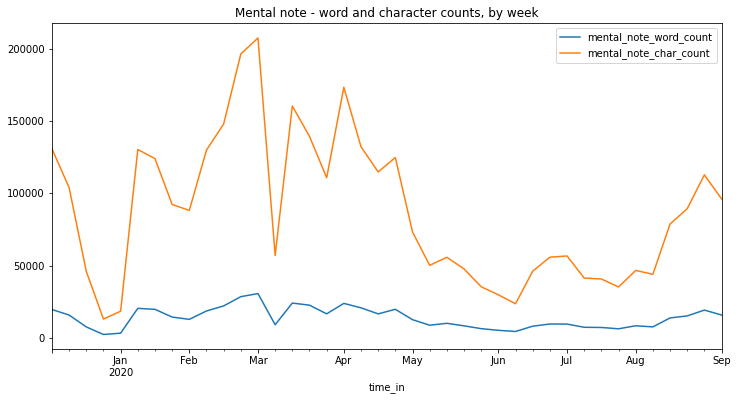

In [32]:
# Lineplot of mental monthly word/character counts
counts_sum_by_week[["mental_note_word_count", "mental_note_char_count"]].plot(figsize=(12, 6));
plt.title("Mental note - word and character counts, by week");

Considering that I put all of my coding journals into this journal as well, it makes sense that the time I spent working on Trash Panda also had me putting a lot more into the mental notes.

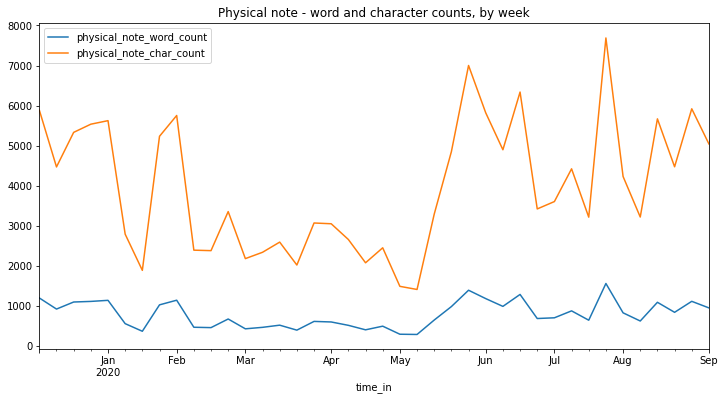

In [33]:
# Lineplot of physical monthly word/character counts
counts_sum_by_week[["physical_note_word_count", "physical_note_char_count"]].plot(figsize=(12, 6));
plt.title("Physical note - word and character counts, by week");

An interesting aspect of the physical word and character counts is that I started getting back into my daily exercising routine, including my return to learning how to trick. It is interesting that the physical notes also increased so much during Trash Panda as well — I guess I was just writing more in general.

#### Character/word ratio

One last thing I'm going to look at is the ratio between character and word counts, which gives an idea of the size of the words I'm using.

In [36]:
# Get ratio of words/characters
counts_sum_by_week_2 = counts_sum_by_week.copy()
counts_sum_by_week_2["mental_char_word_ratio"] = counts_sum_by_week_2["mental_note_char_count"] / counts_sum_by_week_2["mental_note_word_count"]
counts_sum_by_week_2["physical_char_word_ratio"] = counts_sum_by_week_2["physical_note_char_count"] / counts_sum_by_week_2["physical_note_word_count"]

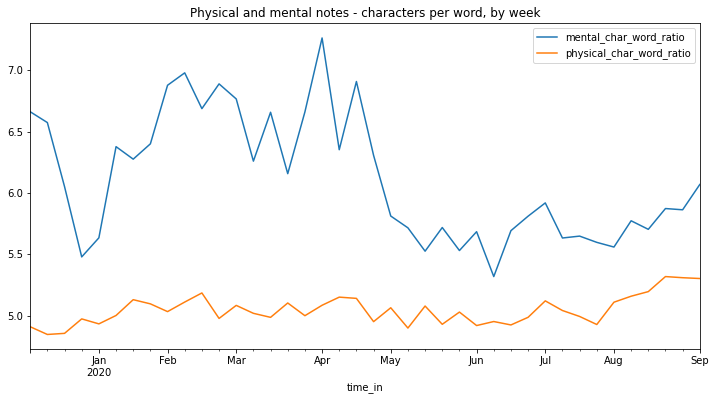

In [35]:
# Plot ratios over time
counts_sum_by_week_2[["mental_char_word_ratio", "physical_char_word_ratio"]].plot(figsize=(12, 6));
plt.title("Physical and mental notes - characters per word, by week");

I imagine that the reason the number of characters per word increased around April is that I spent that time studing into computer science, which likely has longer words than what I use normally. Along with that was a general increase in my learning, as I went deep into that problem-solving mindset.

---

## Final Thoughts

These explorations are only the very beginning of a scratch on the surface of the information contained in the data. But they are a good first step!

I believe that the data will truly start to shine once the actual text contained within the records are added to the analysis, as I will hopefully be able to quantify some deeper aspects of my experience.

As always, thank you for reading, and I'll see you in the next one!